In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import json
import nltk

%matplotlib inline

In [2]:
path_to_data = './data'

# create dataframe from sessions.json
df = pd.read_json(f'{path_to_data}/sessions.json')
df.head()

# create dictionaries for switching between symptom and id
id2sym = {}
sym2id = {}

with open(f'{path_to_data}/symptoms.json') as json_file:
    data = json.load(json_file)
    for sym in data:
        id2sym[sym['id']] = sym['name']
        sym2id[sym['name']] = sym['id']
        
# add column with the symptom names
sym_names = []

for syms in df['confirmed']:
    if len(syms) != 0:
        sym_names.append([id2sym[x] for x in syms])
    else:
        sym_names.append([])

df['labels'] = sym_names

In [3]:
df.head()

,text,confirmed,suggested,labels
0,Slut på medicin.,"[89, 651]",[348],"[Känd astma, Känd lungsjukdom]"
1,Ångest,[],[118],[]
2,"Tänkte bara höra med Er, när jag har möjlighet...",[],"[89, 913]",[]
3,Behöver att prata med psykolog angående använd...,"[116, 215]","[215, 348, 446]","[Nedstämdhet, Trötthet]"
4,Har fått besvärlig eksem på händerna,"[2, 141]",[141],"[Hudbesvär, Synliga hudbesvär]"


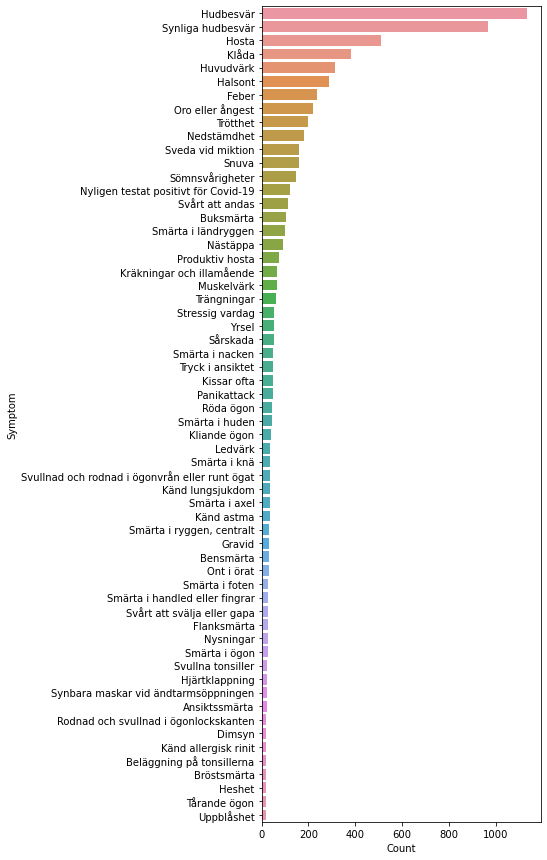

In [4]:
# plot the distribution of labels
all_syms = sum(sym_names,[])
all_syms = nltk.FreqDist(all_syms)

all_syms_df = pd.DataFrame({'Symptom': list(all_syms.keys()),
                            'Count': list(all_syms.values())
                           })

g = all_syms_df.nlargest(columns='Count', n=60)
plt.figure(figsize=(5,15))
ax = sns.barplot(data=g, x='Count', y='Symptom')

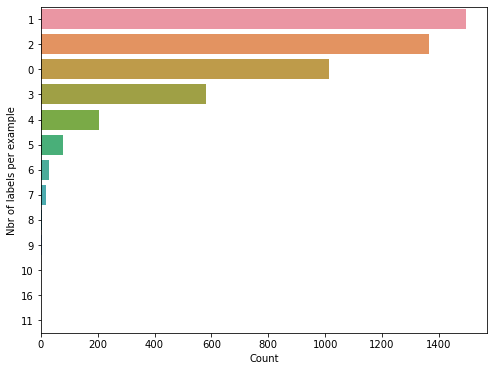

In [5]:
# plot the distribution of number of labels per example
count_list = []

for sym_list in df['labels']:
    count_list.append(f'{len(sym_list)}')
    
count_dict = nltk.FreqDist(count_list)
count_dict_df = pd.DataFrame({'Nbr of labels per example': list(count_dict.keys()),
                              'Count': list(count_dict.values())
                             })

g = count_dict_df.nlargest(columns='Count', n=60)
plt.figure(figsize=(8,6))
ax = sns.barplot(data=g, x='Count', y='Nbr of labels per example')

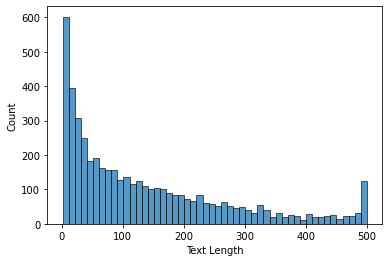

In [6]:
# plot the distribution of text lengths
length_list = []

for text in df['text']:
    length_list.append(len(text))

length_list_df = pd.DataFrame({'Text Length': length_list})

ax = sns.histplot(data=length_list_df, x='Text Length', bins=50)

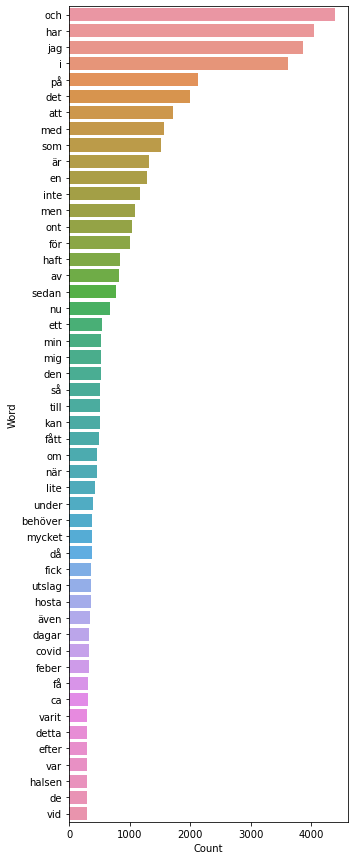

In [19]:
# plot the distribution of words
def clean_text(text):
    # turn text to lowercase
    text = text.lower()
    
    # remove all characters that are not letters or whitespace
    text = re.sub(r'[^\p{L} ]', '', text)
    
    return text

words = df['text'].tolist()
all_words = [clean_text(x).split() for x in words]
all_words = sum(all_words,[])
all_words = nltk.FreqDist(all_words)

all_words_df = pd.DataFrame({'Word': list(all_words.keys()),
                            'Count': list(all_words.values())
                           })

g = all_words_df.nlargest(columns='Count', n=50)
plt.figure(figsize=(5,15))
ax = sns.barplot(data=g, x='Count', y='Word')